In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
%matplotlib inline

In [25]:
from time import time

In [2]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [3]:
train.head()

,User_ID,Description,Browser_Used,Device_Used,Is_Response
0,id10326,The room was kind of clean but had a VERY stro...,Edge,Mobile,not happy
1,id10327,I stayed at the Crown Plaza April -- - April -...,Internet Explorer,Mobile,not happy
2,id10328,I booked this hotel through Hotwire at the low...,Mozilla,Tablet,not happy
3,id10329,Stayed here with husband and sons on the way t...,InternetExplorer,Desktop,happy
4,id10330,My girlfriends and I stayed here to celebrate ...,Edge,Tablet,not happy


In [4]:
train.describe()

,User_ID,Description,Browser_Used,Device_Used,Is_Response
count,38932,38932,38932,38932,38932
unique,38932,38932,11,3,2
top,id26187,We were privledged to stay at the Inn at Cherr...,Firefox,Desktop,happy
freq,1,1,7367,15026,26521


In [5]:
test.head()

,User_ID,Description,Browser_Used,Device_Used
0,id80132,Looking for a motel in close proximity to TV t...,Firefox,Mobile
1,id80133,Walking distance to Madison Square Garden and ...,InternetExplorer,Desktop
2,id80134,Visited Seattle on business. Spent - nights in...,IE,Tablet
3,id80135,This hotel location is excellent and the rooms...,Edge,Mobile
4,id80136,This hotel is awesome I love the service Antho...,Mozilla,Mobile


In [6]:
train.shape, test.shape

((38932, 5), (29404, 4))

In [7]:
train['Is_Response']=train['Is_Response'].map({'happy':1,'not happy':0}).astype(int)

In [8]:
train[['Browser_Used' , 'Is_Response']].groupby(['Browser_Used'], as_index=False).mean().sort_values(by='Is_Response',ascending=False)

,Browser_Used,Is_Response
5,Internet Explorer,0.877318
3,Google Chrome,0.866066
6,InternetExplorer,0.864647
4,IE,0.860599
0,Chrome,0.851417
8,Mozilla Firefox,0.740065
10,Safari,0.728205
9,Opera,0.665746
7,Mozilla,0.595408
2,Firefox,0.500204


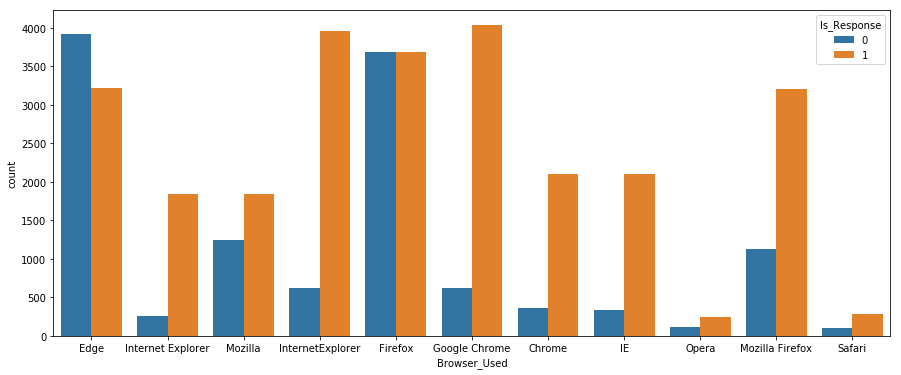

In [9]:
plt.figure(figsize=(15,6))
sns.countplot(x='Browser_Used',data=train,hue='Is_Response')

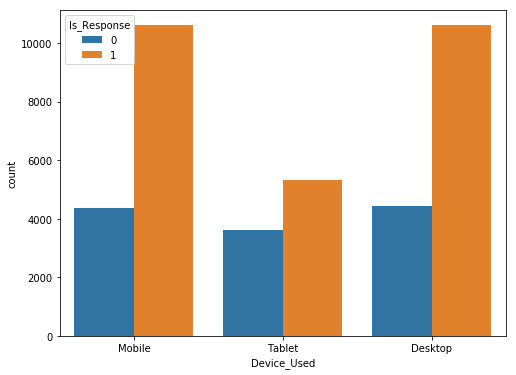

In [10]:
plt.figure(figsize=(8,6))
sns.countplot(x='Device_Used',data=train,hue='Is_Response')

In [11]:
train[['Device_Used' , 'Is_Response']].groupby(['Device_Used'], as_index=False).mean().sort_values(by='Is_Response',ascending=False)

,Device_Used,Is_Response
1,Mobile,0.707933
0,Desktop,0.705111
2,Tablet,0.596193


In [12]:
stop_words=set(stopwords.words('english'))

In [14]:
def cleanData(text, lowercase = False, remove_stops = False, stemming = False):
    txt = str(text)
    txt = re.sub(r'[^A-Za-z0-9\s]',r'',txt)
    txt = re.sub(r'\n',r' ',txt)
    
    if lowercase:
        txt = " ".join([w.lower() for w in txt.split()])
        
    if remove_stops:
        txt = " ".join([w for w in txt.split() if w not in stop_words])
    
    if stemming:
        st = PorterStemmer()
        txt = " ".join([st.stem(w) for w in txt.split()])

    return txt

In [15]:
combined = pd.concat([train, test],copy=True).reset_index(drop=True)

In [19]:
combined.head()

,Browser_Used,Description,Device_Used,Is_Response,User_ID
0,Edge,The room was kind of clean but had a VERY stro...,Mobile,0.0,id10326
1,Internet Explorer,I stayed at the Crown Plaza April -- - April -...,Mobile,0.0,id10327
2,Mozilla,I booked this hotel through Hotwire at the low...,Tablet,0.0,id10328
3,InternetExplorer,Stayed here with husband and sons on the way t...,Desktop,1.0,id10329
4,Edge,My girlfriends and I stayed here to celebrate ...,Tablet,0.0,id10330


In [20]:
combined.tail()

,Browser_Used,Description,Device_Used,Is_Response,User_ID
68331,Chrome,I stayed at the hotel and towers for a confere...,Mobile,NaN,id109531
68332,Internet Explorer,Trying to stay within the Marriott family and ...,Tablet,NaN,id109532
68333,Edge,"We stayed for - nights with our little dog,ver...",Desktop,NaN,id109533
68334,InternetExplorer,Stayed at the Yotel over the weekend and was v...,Desktop,NaN,id109534
68335,Mozilla Firefox,The Blakely is is comfortable is every way: th...,Mobile,NaN,id109535


In [21]:
combined['Description']=combined['Description'].map(lambda x:cleanData(x, lowercase=True, remove_stops=True, stemming=True))

In [23]:
combined['Description'].tail()

68331    stay hotel tower confer love place room spacio...
68332    tri stay within marriott famili want pay park ...
68333    stay night littl dogveri friendli staff ask se...
68334    stay yotel weekend impress thing like best sof...
68335    blake comfort everi way room nice furnish lnen...
Name: Description, dtype: object

In [27]:
countvec=CountVectorizer(analyzer='word',ngram_range=(1,1),min_df=150,max_features=500)
tfidfvec=TfidfVectorizer(analyzer='word',ngram_range=(1,1),min_df=150,max_features=500)

In [36]:
bag_of_words=countvec.fit_transform(combined['Description'])

tfidf_data=tfidfvec.fit_transform(combined['Description'])

In [37]:
bag_of_words

<68336x500 sparse matrix of type '<type 'numpy.int64'>'
	with 2856691 stored elements in Compressed Sparse Row format>

In [38]:
tfidf_data

<68336x500 sparse matrix of type '<type 'numpy.float64'>'
	with 2856691 stored elements in Compressed Sparse Row format>

In [39]:
features=['Browser_Used','Device_Used']

for x in features:
    lbl=LabelEncoder()
    combined[x]=lbl.fit_transform(combined[x])

In [40]:
combined.dtypes

Browser_Used      int64
Description      object
Device_Used       int64
Is_Response     float64
User_ID          object
dtype: object

In [61]:
bag_df=pd.DataFrame(bag_of_words.todense())
tfidf_df=pd.DataFrame(tfidf_data.todense())

In [62]:
bag_df.columns = ['word'+ str(x) for x in bag_df.columns]
tfidf_df.columns = ['word' + str(x) for x in tfidf_df.columns]

In [63]:
bag_df.columns

Index([u'word0', u'word1', u'word2', u'word3', u'word4', u'word5', u'word6',
       u'word7', u'word8', u'word9',
       ...
       u'word490', u'word491', u'word492', u'word493', u'word494', u'word495',
       u'word496', u'word497', u'word498', u'word499'],
      dtype='object', length=500)

In [64]:
bow_df_train=bag_df[:len(train)]
bow_df_test=bag_df[len(train):]

tfid_df_train = tfidf_df[:len(train)]
tfid_df_test = tfidf_df[len(train):]

In [65]:
#split merged alldata back to train and test

train_feats=combined[~pd.isnull(combined.Is_Response)]
test_feats=combined[pd.isnull(combined.Is_Response)]

train_feats.shape, test_feats.shape

((38932, 5), (29404, 5))

In [66]:
train_feats.head()

,Browser_Used,Description,Device_Used,Is_Response,User_ID
0,1,room kind clean strong smell dog gener averag ...,1,0.0,id10326
1,5,stay crown plaza april april staff friendli at...,1,0.0,id10327
2,7,book hotel hotwir lowest price could find got ...,2,0.0,id10328
3,6,stay husband son way alaska cruis love hotel g...,0,1.0,id10329
4,1,girlfriend stay celebr th birthday plan weeken...,2,0.0,id10330


In [67]:
train_feats_bow=pd.concat([train_feats[features],bow_df_train],axis=1)
test_feats_bow=pd.concat([test_feats[features],bow_df_test],axis=1)

test_feats_bow.reset_index(drop=True,inplace=True)

train_feats_bow.shape , test_feats_bow.shape

((38932, 502), (29404, 502))

In [68]:
train_feats_bow.head()

,Browser_Used,Device_Used,word0,word1,word2,word3,word4,word5,word6,word7,...,word490,word491,word492,word493,word494,word495,word496,word497,word498,word499
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,5,1,0,0,0,0,0,0,0,0,...,0,0,1,0,2,0,0,0,0,0
2,7,2,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
3,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,2,0,0,0,0,0,0,0,0,...,0,1,0,1,3,0,0,0,0,0


In [69]:
train_feats2 = pd.concat([train_feats[features], tfid_df_train], axis=1)
test_feats2 = pd.concat([test_feats[features], tfid_df_test], axis=1)

In [70]:
# for classification

target=train_feats['Is_Response']

In [71]:
model1=GaussianNB()

In [75]:
from sklearn.metrics import make_scorer

In [76]:
#checking cv score on bag of words data
print(cross_val_score(model1,train_feats_bow,target,cv=5,scoring=make_scorer(accuracy_score)))

[0.77208526 0.76110968 0.76740303 0.76663242 0.77626509]


In [78]:
#Checking cv score for tf-idf

print(cross_val_score(model1,train_feats2,target,cv=5,scoring=make_scorer(accuracy_score)))


[0.80906523 0.81518109 0.80901618 0.81312612 0.80349345]


In [79]:
from sklearn.linear_model import  LogisticRegression
from sklearn.ensemble import RandomForestClassifier
model2=LogisticRegression()
model3=GradientBoostingClassifier()
model4=RandomForestClassifier()

In [80]:
#checking cv score on bag of words data
#LogisticRegression
print(cross_val_score(model2,train_feats_bow,target,cv=5,scoring=make_scorer(accuracy_score)))

[0.85927067 0.86681223 0.86141793 0.86141793 0.86450039]


In [83]:
#Checking cv score for tf-idf

print(cross_val_score(model2,train_feats2,target,cv=5,scoring=make_scorer(accuracy_score)))
print np.mean(cross_val_score(model2,train_feats2,target,cv=5,scoring=make_scorer(accuracy_score)))

[0.85914227 0.87117904 0.86462882 0.86861033 0.8688672 ]
0.8664855308363647


In [84]:
#checking cv score on bag of words data
#GradientBoostingClassifier
print(cross_val_score(model3,train_feats_bow,target,cv=5,scoring=make_scorer(accuracy_score)))

[0.83795583 0.84664783 0.84536347 0.84677627 0.84433599]


In [87]:
#Checking cv score for tf-idf

print(cross_val_score(model3,train_feats2,target,cv=5,scoring=make_scorer(accuracy_score)))
print np.mean(cross_val_score(model3,train_feats2,target,cv=5,scoring=make_scorer(accuracy_score)))

[0.83859784 0.84369381 0.84664783 0.84703314 0.84433599]
0.8440360340178353


In [88]:
#checking cv score on bag of words data
#RandomForestClassifierdomForest
print(cross_val_score(model4,train_feats_bow,target,cv=5,scoring=make_scorer(accuracy_score)))

[0.8027735  0.80708965 0.80670434 0.80464937 0.80118161]


In [89]:
#Checking cv score for tf-idf

print(cross_val_score(model4,train_feats2,target,cv=5,scoring=make_scorer(accuracy_score)))
print np.mean(cross_val_score(model4,train_feats2,target,cv=5,scoring=make_scorer(accuracy_score)))

[0.80996405 0.81582327 0.8155664  0.81415361 0.81582327]
0.8186838848282466
